# Structure of the project

```
Student_Performance_Prediction/
│── app.py                  # Flask app with CRUD + ML prediction
│── student_model.pkl       # Saved ML model
│── students_train.csv      # CSV dataset (used for training)
│── student_model.ipynb     # Jupyter Notebook: EDA, training, model saving
│── env/                    # Python virtual environment
│── templates/
│   ├── base.html           # Common layout (navigation + CSS)
│   ├── index.html          # Display all students + CRUD buttons
│   ├── add_student.html    # Form to add a student
│   └── update_student.html # Form to update student
│── static/
│   └── style.css           # CSS styling
```


---
---

# **Step-by-Step Procedure**

---

## **Step 1: Project Setup**

1. **Create project folder:**

   ```bash
   mkdir Student_Performance_Prediction
   cd Student_Performance_Prediction
   ```

2. **Create virtual environment and activate:**

   ```bash
   python -m venv env
   ```

   * Windows: `env\Scripts\activate`
   * Mac/Linux: `source env/bin/activate`

3. **Install required packages:**

   ```bash
   pip install flask flask_sqlalchemy scikit-learn pandas matplotlib seaborn joblib
   ```

✅ This ensures your Flask app, database, and ML model will work.

---

## **Step 2: Prepare Dataset & Train ML Model**

**File:** `student_model.ipynb`

1. **Import Libraries:**

   ```python
   import pandas as pd
   import numpy as np
   import matplotlib.pyplot as plt
   import seaborn as sns
   from sklearn.model_selection import train_test_split
   from sklearn.linear_model import LogisticRegression
   from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
   import joblib
   ```

2. **Create Dataset (5 subjects + total + performance):**

   ```python
   data = {
       "name": ["Alice","Bob","Charlie","David","Eva"],
       "age": [20,22,21,23,20],
       "math": [85,45,70,30,95],
       "science":[78,50,60,35,92],
       "english":[80,55,65,32,90],
       "history":[82,48,68,34,94],
       "computer":[90,40,72,28,96],
       "performance":["Pass","Fail","Pass","Fail","Pass"]
   }
   df = pd.DataFrame(data)
   df["total"] = df[["math","science","english","history","computer"]].sum(axis=1)
   df.to_csv("students_train.csv", index=False)
   ```

3. **EDA (Exploratory Data Analysis):**

   ```python
   sns.scatterplot(x="total", y="age", hue="performance", data=df)
   plt.show()

   sns.heatmap(df[["math","science","english","history","computer","total"]].corr(), annot=True)
   plt.show()
   ```

4. **Train-Test Split & Model Training:**

   ```python
   X = df[["age","total"]]
   y = df["performance"]

   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
   model = LogisticRegression()
   model.fit(X_train, y_train)
   ```

5. **Evaluate Model:**

   ```python
   y_pred = model.predict(X_test)
   print("Accuracy:", accuracy_score(y_test, y_pred))
   print(confusion_matrix(y_test, y_pred))
   print(classification_report(y_test, y_pred))
   ```

6. **Save Model:**

   ```python
   joblib.dump(model, "student_model.pkl")
   ```

✅ Now you have a **trained ML model** and dataset ready for Flask integration.

---

## **Step 3: Flask App Setup**

**File:** `app.py`

1. **Import Libraries:**

   ```python
   from flask import Flask, render_template, request, redirect, url_for
   from flask_sqlalchemy import SQLAlchemy
   import joblib
   ```

2. **Initialize App and Database:**

   ```python
   app = Flask(__name__)
   app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///students.db'
   db = SQLAlchemy(app)
   model = joblib.load("student_model.pkl")
   ```

3. **Create Database Model (`Student`):**

   ```python
   class Student(db.Model):
       id = db.Column(db.Integer, primary_key=True)
       name = db.Column(db.String(50), nullable=False)
       age = db.Column(db.Integer, nullable=False)
       math = db.Column(db.Float, nullable=False)
       science = db.Column(db.Float, nullable=False)
       english = db.Column(db.Float, nullable=False)
       history = db.Column(db.Float, nullable=False)
       computer = db.Column(db.Float, nullable=False)
       total = db.Column(db.Float, nullable=False)
       performance = db.Column(db.String(10), nullable=False)
   ```

4. **Create DB Tables:**

   ```python
   with app.app_context():
       db.create_all()
   ```

---

## **Step 4: CRUD Operations**

1. **Read (List Students):**

   ```python
   @app.route('/')
   def index():
       students = Student.query.all()
       return render_template('index.html', students=students)
   ```

2. **Create (Add Student):**

   ```python
   @app.route('/add', methods=['GET', 'POST'])
   def add_student():
       if request.method == 'POST':
           name = request.form['name']
           age = int(request.form['age'])
           math = float(request.form['math'])
           science = float(request.form['science'])
           english = float(request.form['english'])
           history = float(request.form['history'])
           computer = float(request.form['computer'])
           total = math + science + english + history + computer
           performance = model.predict([[age, total]])[0]

           student = Student(name=name, age=age, math=math, science=science,
                             english=english, history=history, computer=computer,
                             total=total, performance=performance)
           db.session.add(student)
           db.session.commit()
           return redirect(url_for('index'))
       return render_template('add_student.html')
   ```

3. **Update Student:**

   ```python
   @app.route('/update/<int:id>', methods=['GET','POST'])
   def update_student(id):
       student = Student.query.get(id)
       if request.method == 'POST':
           student.name = request.form['name']
           student.age = int(request.form['age'])
           student.math = float(request.form['math'])
           student.science = float(request.form['science'])
           student.english = float(request.form['english'])
           student.history = float(request.form['history'])
           student.computer = float(request.form['computer'])
           student.total = student.math + student.science + student.english + student.history + student.computer
           student.performance = model.predict([[student.age, student.total]])[0]
           db.session.commit()
           return redirect(url_for('index'))
       return render_template('update_student.html', student=student)
   ```

4. **Delete Student:**

   ```python
   @app.route('/delete/<int:id>')
   def delete_student(id):
       student = Student.query.get(id)
       db.session.delete(student)
       db.session.commit()
       return redirect(url_for('index'))
   ```

---

## **Step 5: Templates**

* **base.html:** Navigation menu + link to CSS
* **index.html:** List students table + CRUD buttons
* **add_student.html:** Form to add student
* **update_student.html:** Form to update student

Use **Jinja2** variables like `{{ student.name }}`.

---

## **Step 6: Static Files**

* **style.css:** Styling for tables, buttons, and forms
* Link it in `base.html`:

```html
<link rel="stylesheet" href="{{ url_for('static', filename='style.css') }}">
```

---

## **Step 7: Run Flask App**

1. Run:

```bash
python app.py
```

2. Open browser:

```
http://127.0.0.1:5000/
```

3. You can now:

* Add students
* Update subject marks
* Automatically predict performance (`Pass/Fail`)
* Delete students

---


**Add/Update Student flow**:

### **Flow Explanation**

1. **User submits form** in the browser (Add or Update student).
2. **Flask app** receives request, validates inputs, calculates total marks.
3. **Flask app** calls **ML model** with age + total to predict performance (`Pass/Fail`).
4. **ML model** returns prediction to Flask.
5. **Flask app** inserts/updates the student record in the **database**, including the predicted performance.
6. **Flask app** renders the appropriate **HTML template**.
7. **User sees the updated student info and performance prediction** in the browser.

This gives a **clear internal data flow** for CRUD + ML prediction.






### **Workflow Explanation**

1. **User (Web Browser)**:

   * Adds, updates, views, or deletes student data via forms.
2. **Flask App (`app.py`)**:

   * Receives the HTTP request, processes data, calls DB or ML model.
3. **Database (SQLite + SQLAlchemy)**:

   * Stores student records and handles CRUD operations.
4. **ML Model (`student_model.pkl`)**:

   * Predicts student performance (`Pass`/`Fail`) based on total marks and age.
5. **HTML Response (Templates)**:

   * Renders the response back to the user showing student data and prediction.

This shows the **full cycle from user input to response** with **CRUD + ML integration**.




 **“View/Delete Student” flow** 
---

### **Flow Explanation**

1. **View Student**

   * User requests the student list from the browser.
   * Flask app queries the database for all student records.
   * Database returns the student data to Flask.
   * Flask renders the HTML template with student data.
   * User sees the full student list in the browser.

2. **Delete Student**

   * User clicks delete for a specific student.
   * Flask app deletes the student record from the database.
   * Database confirms deletion.
   * Flask renders the updated student list template.
   * User sees the updated student list in the browser.

---



---
This diagram will give you a **single visual reference** showing:

* **Add Student → ML Prediction → DB Insert → Template Render → User**
* **Update Student → ML Prediction → DB Update → Template Render → User**
* **View Student → DB Query → Template Render → User**
* **Delete Student → DB Delete → Template Render → User**

---



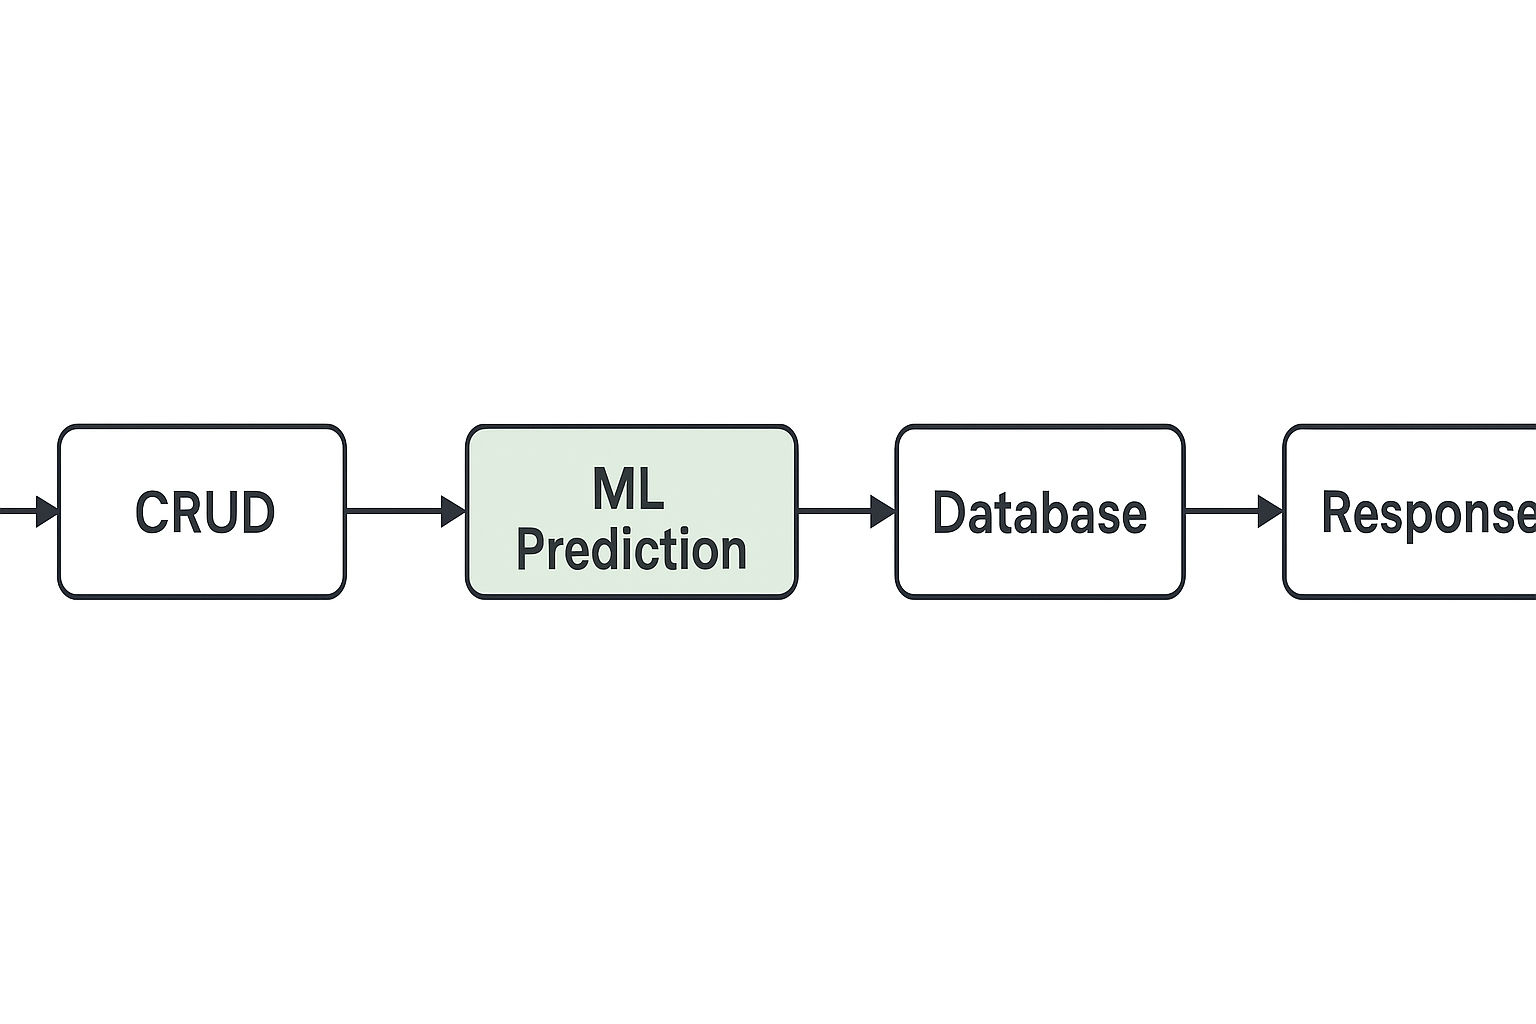